In [1]:
%matplotlib inline

import glob
import os

import numpy as np
import scipy as sp
import dask
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.collections as collections
import matplotlib.gridspec as gridspec
import mpl_toolkits.axes_grid1 as axtk
import matplotlib
# import sklearn
# from sklearn.linear_model import LinearRegression
import skimage
# import seaborn as sns
import string
import pandas as pd
# from tqdm.notebook import trange, tqdm
# from pytictoc import TicToc

# from saranfo import InfoTheoryDataset
# import saranfo

import deltametrics as dm
from pyDeltaRCM.shared_tools import scale_model_time
from _analysis import utilities

# import infotheory
# import ite

import statsmodels.stats.weightstats as weightstats
import statsmodels.api as sm

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


Experimental Set 1 and Set 2 are referred to by the name of real-world deltas that share qualitative similarities.
This is simply because it is much easier for me to keep things straight using names than numbers.

For reference:
* anything with `selenga` refers to Set 1 
* anything with `mississippi` refers to Set 2 

In [2]:
If = If = (7 / 365.25)

selenga_set = '/scratch/faults_set1/'
mississippi_set = '/scratch/faults_set2'

selenga_spinups_fldrs = [f.path for f in os.scandir(os.path.join(selenga_set, 'spin_up')) if f.is_dir()]
selenga_matrix_fldrs = [f.path for f in os.scandir(os.path.join(selenga_set, 'matrix')) if f.is_dir()]
mississippi_spinups_fldrs = [f.path for f in os.scandir(os.path.join(mississippi_set, 'spin_up')) if f.is_dir()]
mississippi_matrix_fldrs = [f.path for f in os.scandir(os.path.join(mississippi_set, 'matrix')) if f.is_dir()]

selenga_matrix_fldrs.sort()
mississippi_matrix_fldrs.sort()

selenga_SPINUPS_SAMPLE = dm.cube.DataCube(
    os.path.join(selenga_spinups_fldrs[0], 'pyDeltaRCM_output.nc'))
selenga_CUBES_SAMPLE = dm.cube.DataCube(
    os.path.join(selenga_matrix_fldrs[55], 'pyDeltaRCM_output.nc'))
mississippi_SPINUPS_SAMPLE = dm.cube.DataCube(
    os.path.join(mississippi_spinups_fldrs[0], 'pyDeltaRCM_output.nc'))
mississippi_CUBES_SAMPLE = dm.cube.DataCube(
    os.path.join(mississippi_matrix_fldrs[-1], 'pyDeltaRCM_output.nc'))

selenga_cubes = []
for i, fldr in enumerate(selenga_matrix_fldrs):
    data = dm.cube.DataCube(os.path.join(fldr, 'pyDeltaRCM_output.nc'))
    selenga_cubes.append(data)
mississippi_cubes = []
for i, fldr in enumerate(mississippi_matrix_fldrs):
    data = dm.cube.DataCube(os.path.join(fldr, 'pyDeltaRCM_output.nc'))
    mississippi_cubes.append(data)

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# figure settings
DPI = 90

# provide the colormaps
selenga_cube_cm = matplotlib.cm.get_cmap('copper', 9)
mississippi_cube_cm = matplotlib.cm.get_cmap('cividis', 3)
carto_cm, carto_norm = dm.plot.cartographic_colormap(H_SL=0, h=3, n=1)
error_alpha = 0.3

connect_colors_str = ['darkgray',  'firebrick']
connect_colors = [matplotlib.colors.to_rgb(col) for col in connect_colors_str]
connect_hexcolor = map(lambda rgb:'#%02x%02x%02x' % (int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)),
               tuple(connect_colors))
connect_cmap = matplotlib.colors.ListedColormap(np.array(connect_colors)/255)

# provide a consistent setting for background on plots
bg_color = '0.9'
BACKGROUND_SET = 'meanstd'

# provide a consistent mapping for the time axis on all plots
selenga_t_lim = (-100, 250)
mississippi_t_lim = (-200, 650)
selenga_breakline_time = scale_model_time(selenga_SPINUPS_SAMPLE.t[-1], If=If, units='years')
mississippi_breakline_time = scale_model_time(mississippi_SPINUPS_SAMPLE.t[-1], If=If, units='years')

# consistent annotations
arrowpropsdict = dict(arrowstyle='-|>', shrinkA=0, edgecolor='k', facecolor='k')

In [4]:
FOR_WHICH = 'paper'
if FOR_WHICH == 'paper':
    _tick_fontsize = 7
    _label_fontsize = 8
    _colorbar_tick_fontsize = 6
    _colorbar_label_fontsize = 8

## Introduction figure

In [5]:
def _hack_map_axis_labels(_ax, _cube):
    _x_step = round(_cube.shape[2] / 5)
    _x_samp = np.arange(0, _cube.shape[2], step=_x_step)
    _ax.set_xticks(_cube.x[_x_samp])
    _ax.set_xticklabels((
        _cube.x[_x_samp] * _cube.meta['dx'].data / 1000).astype(np.int))
    _y_step = round(_cube.shape[1] / 5)
    _y_samp = np.arange(0, _cube.shape[1], step=_y_step)
    _ax.set_yticks(_cube.y[_y_samp])
    _ax.set_yticklabels((
        _cube.y[_y_samp] * _cube.meta['dx'].data / 1000).astype(np.int))
    _ax.xaxis.set_tick_params(labelsize=_tick_fontsize)
    _ax.yaxis.set_tick_params(labelsize=_tick_fontsize)
    
# define a custom tick formatter
@ticker.FuncFormatter
def _elev_formatter(x, pos):
    return f'{x:.1f}'

def _axes_letter_getter(i):
    return chr(ord('a') + i)+')'

In [6]:
def compute_ecdf(data):
    sort = np.sort(data)
    prob = np.arange(len(sort))/float(len(sort))
    return sort, prob

In [7]:
selenga_SPINUPS_SAMPLE.shape

(410, 133, 267)

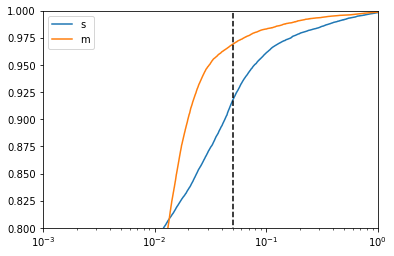

In [8]:
# make correlation arrays
def compute_connection_strength_array(cube, t):
    Hbf = cube.meta['h0'].data
    qw0 = (cube.meta['u0'][0].data * Hbf)
    corr = np.array(cube['discharge'][t, :, :].squeeze()) / qw0
#     corr /= np.max(corr)
    return corr


selenga_corr = compute_connection_strength_array(
    selenga_SPINUPS_SAMPLE, t=-1)


mississippi_corr = compute_connection_strength_array(
    mississippi_SPINUPS_SAMPLE, t=-1)


# make simple plots of the cdfs of discharge to determine where to clip
s_ecdf_sort, s_ecdf_prob = compute_ecdf(selenga_corr.flatten())
m_ecdf_sort, m_ecdf_prob = compute_ecdf(mississippi_corr.flatten())

fig, ax = plt.subplots(1)
ax.plot(s_ecdf_sort, s_ecdf_prob, '-', label='s')
ax.plot(m_ecdf_sort, m_ecdf_prob, '-', label='m')
ax.legend()
ax.set_xscale('log')
ax.set_xlim(0.001, 1)
ax.set_ylim(0.8, 1)
ax.plot([.05, .05], [0, 1], 'k--')
plt.show()

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/anaconda3/envs/faults/lib/python3.7/site-packages/

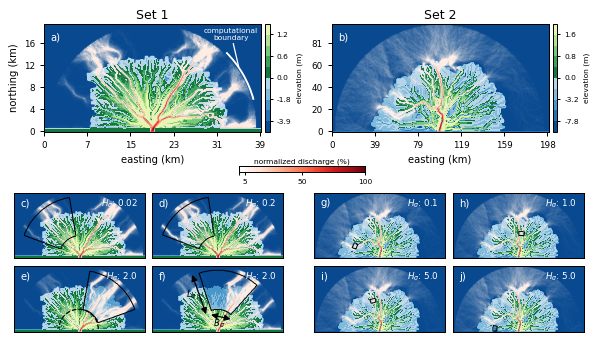

In [9]:
%matplotlib inline

selenga_overlay_clip = (np.interp(0.05, s_ecdf_sort, s_ecdf_prob), 93)  # (None, 90)
mississippi_overlay_clip = (np.interp(0.05, m_ecdf_sort, m_ecdf_prob), 97)  # (80, 95)

fig = plt.figure(figsize=(6.75, 3.8), dpi=DPI)

# top gridspec
top_gs = fig.add_gridspec(nrows=1, ncols=2,
                      left=0.075, right=0.92,
                      bottom=0.58, top=0.95,
                      wspace=0.275)

# top selenga plot
ax_stop = fig.add_subplot(top_gs[0])
cb = dm.plot.aerial_view(
    selenga_SPINUPS_SAMPLE['eta'][-1, :, :],
    ax=ax_stop, ticks=True,
    colorbar_kw={'labelsize': _colorbar_tick_fontsize,
                 'format': _elev_formatter},
    h=5, n=1.5)
cb.ax.yaxis.set_tick_params(labelsize=_colorbar_tick_fontsize, length=2)
cb.set_label('elevation (m)', fontsize=_colorbar_tick_fontsize)
_hack_map_axis_labels(ax_stop, selenga_SPINUPS_SAMPLE)
dm.plot.overlay_sparse_array(
    selenga_corr, ax=ax_stop, alpha_clip=selenga_overlay_clip)
_cent = (selenga_SPINUPS_SAMPLE.meta['CTR'].data, selenga_SPINUPS_SAMPLE.meta['L0'].data)
_edge = selenga_SPINUPS_SAMPLE.shape[2] - 7
arc_bound = patches.Arc(_cent, _edge, _edge, angle=0, theta1=15, theta2=45, lw=1.5, color='white')
ax_stop.add_patch(arc_bound)
ax_stop.annotate('computational\nboundary', xy=(240, 76), xytext=(230, 119),
                 arrowprops=dict(arrowstyle='-', edgecolor='white', shrinkA=0),
                 color='white', fontsize=_colorbar_tick_fontsize, rotation=0,
                 ha='center', va='center')
ax_stop.set_title('Set 1', fontsize=10, pad=4)
ax_stop.set_xlabel('easting (km)', fontsize=_label_fontsize)
ax_stop.set_ylabel('northing (km)', fontsize=_label_fontsize)
ax_stop.text(0.03, 0.85, _axes_letter_getter(0),
             fontsize=_label_fontsize,
             color='white', transform=ax_stop.transAxes)

# top mississippi plot
ax_mtop = fig.add_subplot(top_gs[1])
cb = dm.plot.aerial_view(
    mississippi_SPINUPS_SAMPLE['eta'][-1, :, :],
    datum=mississippi_SPINUPS_SAMPLE.meta['H_SL'][-1],
    ax=ax_mtop, ticks=True,
    colorbar_kw={'labelsize': _colorbar_tick_fontsize,
                 'format': _elev_formatter},
    h=10, n=2)
cb.ax.yaxis.set_tick_params(labelsize=_colorbar_tick_fontsize, length=2)
cb.set_label('elevation (m)', fontsize=_colorbar_tick_fontsize)
_hack_map_axis_labels(ax_mtop, mississippi_SPINUPS_SAMPLE)
ovim = dm.plot.overlay_sparse_array(
    mississippi_corr, ax=ax_mtop, alpha_clip=mississippi_overlay_clip)
ax_mtop.set_xlabel('easting (km)', fontsize=_label_fontsize)
ax_mtop.set_title('Set 2', fontsize=10, pad=4)
ax_mtop.text(0.03, 0.85, _axes_letter_getter(1),
             fontsize=_label_fontsize,
             color='white', transform=ax_mtop.transAxes)

# colorbar for discharge array
upcb_pos = cb.ax.get_position()
ovcb_hw = ((upcb_pos.y1 - upcb_pos.y0) / 2)
ovcb_th = ((upcb_pos.x1 - upcb_pos.x0))
ovcb_hw_disp = fig.transFigure.transform((0.1, ovcb_hw))
ovcb_th_disp = fig.transFigure.transform((ovcb_th, 0.1))
ovcb_hw_corr = fig.transFigure.inverted().transform((ovcb_hw_disp[1], 0.1))[0]
ovcb_th_corr = fig.transFigure.inverted().transform((0.1, ovcb_th_disp[0]))[1]
ovax = fig.add_axes([0.5-ovcb_hw_corr, 0.49, 2*ovcb_hw_corr, 0.015])
faux_cb_x, faux_cb_y = np.meshgrid(np.arange(0, 100, 1), np.arange(0, 1, 0.2))
rds = matplotlib.cm.get_cmap('Reds', 100)
faux_im = ovax.imshow(faux_cb_x, extent=[5, 100, 0, 1], cmap=rds, aspect='auto')

ovax.set_yticks([])
ovax.set_xticks([0, 5, 50, 100])
ovax.set_xlim(0, 100)
ovax.set_xticklabels(['', '5', '50', '100'])
ovax.set_title('normalized discharge (%)', fontsize=_colorbar_tick_fontsize, pad=3)
ovax.xaxis.set_tick_params(labelsize=_colorbar_tick_fontsize, length=2)


# bottom gridspec
bot_gs_top = 0.44
bot_gs_left = fig.add_gridspec(nrows=2, ncols=2,
                          left=0.025, right=0.48,
                          bottom=0.01, top=bot_gs_top,
                          wspace=0.001, hspace=0.001)
bot_gs_right = fig.add_gridspec(nrows=2, ncols=2,
                          left=0.52, right=0.975,
                          bottom=0.01, top=bot_gs_top,
                          wspace=0.001, hspace=0.001)

# plot for bottoms
selenga_selected_idxs = [20, 40, 60, 61]
selenga_selected_axes = []
for i, idx in enumerate(selenga_selected_idxs):
    _icube = selenga_cubes[idx]
    # add the subplot
    ax_si = fig.add_subplot(bot_gs_left[i//2, i%2])
    
    # make the sigma contour
    _subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])
    ax_si.contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75)
    
    # make the correlation array
    selenga_corr = compute_connection_strength_array(_icube, t=0)
    
    # plot it all up
    cb = dm.plot.aerial_view(
        _icube['eta'][0, :, :],
        ax=ax_si, ticks=False, h=5, n=1.5)
    cb.remove()
    dm.plot.overlay_sparse_array(
        selenga_corr, ax=ax_si, alpha_clip=selenga_overlay_clip)
    
    # add a label
    _sig_rnd = np.round(np.array(_icube.meta['sigma']).max(), 2)
    ax_si.text(0.95, 0.8, ' '.join(("$H_\\sigma$:", str(_sig_rnd))),
               color='white', ha='right', fontsize=_tick_fontsize, transform=ax_si.transAxes)
    ax_si.text(0.05, 0.8, _axes_letter_getter(i+2),
               fontsize=_label_fontsize,
               color='white', transform=ax_si.transAxes)
    
    selenga_selected_axes.append(ax_si)

dimension_arrowprops = dict(arrowpropsdict, arrowstyle="<|-|>")

ax_loc = selenga_selected_axes[2]
arc_loc = patches.Arc(_cent, 80, 80, angle=0, theta1=0, theta2=180, lw=1, color='k', ls='--')
ax_loc.add_patch(arc_loc)

ax_bnds = selenga_selected_axes[3]
ax_bnds.annotate('', xy=(115, 35), xytext=(160, 25),
                 arrowprops=dimension_arrowprops)
ax_bnds.annotate('', xy=(80, 120), xytext=(110, 35),
                 arrowprops=dimension_arrowprops)
ax_bnds.text(125, 10, '$B_\\sigma$',
             color='k', fontsize=_tick_fontsize)
ax_bnds.text(70, 70, '$L_\\sigma$',
             color='k', fontsize=_tick_fontsize)
    
mississippi_selected_idxs = [20, 40, 60, 61]
for i, idx in enumerate(mississippi_selected_idxs):
    _icube = mississippi_cubes[idx]
    # add the subplot
    ax_si = fig.add_subplot(bot_gs_right[i//2, i%2])
    
    # make the sigma contour
    _subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])
    ax_si.contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75)
    
    # make the correlation array
    mississippi_corr = compute_connection_strength_array(_icube, t=0)
    
    # plot it all up
    cb = dm.plot.aerial_view(
        _icube['eta'][0, :, :],
        datum=_icube.meta['H_SL'][0],
        ax=ax_si, ticks=False, h=10, n=2)
    cb.remove()
    dm.plot.overlay_sparse_array(
        mississippi_corr, ax=ax_si, alpha_clip=mississippi_overlay_clip)
    
    # add a label
    _sig_rnd = np.round(np.array(_icube.meta['sigma']).max(), 2)
    ax_si.text(0.95, 0.8, ' '.join(("$H_\\sigma$:", str(_sig_rnd))),
               color='white', ha='right', fontsize=_tick_fontsize, transform=ax_si.transAxes)
    ax_si.text(0.05, 0.8, _axes_letter_getter(i+6),
               fontsize=_label_fontsize,
               color='white', transform=ax_si.transAxes)


fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/experiment_setup.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/experiment_setup.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/opt/anaconda3/envs/faults/lib/python3.7/site-packages/

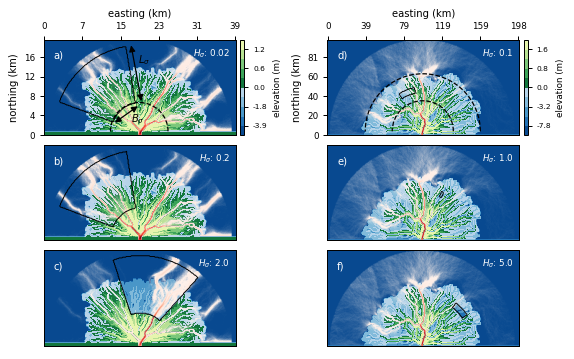

In [10]:
# for poster
fig = plt.figure(figsize=(6, 4), dpi=DPI)

def compute_connection_strength_array(cube, t):
    Hbf = cube.meta['h0'].data
    qw0 = (cube.meta['u0'][0].data * Hbf)
    corr = np.array(cube['discharge'][t, :, :].squeeze()) / qw0
    return corr

# gridspecs
gs_left = fig.add_gridspec(nrows=3, ncols=1,
                          left=0.025, right=0.45,
                          bottom=0.05, top=0.9,
                          wspace=0.01, hspace=0.1)
gs_right = fig.add_gridspec(nrows=3, ncols=1,
                          left=0.55, right=0.975,
                          bottom=0.05, top=0.9,
                          wspace=0.01, hspace=0.1)

selenga_selected_idxs = [20, 40, 61]
mississippi_selected_idxs = [80, 32, 103]
selenga_selected_axes = []
mississippi_selected_axes = []

# plot for bottoms
for i, idx in enumerate(selenga_selected_idxs[:]):
    _icube = selenga_cubes[idx]
    # add the subplot
    ax_si = fig.add_subplot(gs_left[i])
    
    # make the sigma contour
    _subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])
    ax_si.contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75)
    
    # make the correlation array
    selenga_corr = compute_connection_strength_array(_icube, t=0)
    
    # plot it all up
    if i > 0:
        cb = dm.plot.aerial_view(
            _icube['eta'][0, :, :],
            ax=ax_si, ticks=False, h=5, n=1.5)
        cb.remove()
    else:
        cb = dm.plot.aerial_view(
            _icube['eta'][0, :, :],
            ax=ax_si, ticks=True, h=5, n=1.5,
            colorbar_kw={'labelsize': _colorbar_tick_fontsize, 'format': _elev_formatter})
        cb.set_label('elevation (m)', fontsize=_tick_fontsize)
        ax_si.set_xlabel('easting (km)', fontsize=_label_fontsize)
        ax_si.set_ylabel('northing (km)', fontsize=_label_fontsize)
        ax_si.xaxis.tick_top()
        ax_si.xaxis.set_label_position('top')
        _hack_map_axis_labels(ax_si, _icube)
        
    dm.plot.overlay_sparse_array(
        selenga_corr, ax=ax_si, alpha_clip=selenga_overlay_clip)
    
    # add a label
    _sig_rnd = np.round(np.array(_icube.meta['sigma']).max(), 2)
    ax_si.text(0.97, 0.83, ' '.join(("$H_\\sigma$:", str(_sig_rnd))),
               color='white', ha='right', fontsize=_tick_fontsize, transform=ax_si.transAxes)
    ax_si.text(0.05, 0.8, _axes_letter_getter(i),
               fontsize=_label_fontsize,
               color='white', transform=ax_si.transAxes)
    
    selenga_selected_axes.append(ax_si)

dimension_arrowprops = dict(arrowpropsdict, arrowstyle="<|-|>")

_cent = (selenga_SPINUPS_SAMPLE.meta['CTR'].data, selenga_SPINUPS_SAMPLE.meta['L0'].data)
_edge = selenga_SPINUPS_SAMPLE.shape[2] - 7
ax_loc = selenga_selected_axes[0]
arc_loc = patches.Arc(_cent, 80, 80, angle=0, theta1=0, theta2=180, lw=1, color='k', ls='--')
ax_loc.add_patch(arc_loc)

ax_bnds = selenga_selected_axes[0]
ax_bnds.annotate('', xy=(95, 15), xytext=(130, 40),
                 arrowprops=dimension_arrowprops)  # B_sigma
ax_bnds.annotate('', xy=(120, 128), xytext=(135, 47),
                 arrowprops=dimension_arrowprops)
ax_bnds.text(120, 18, '$B_\\sigma$',
             color='k', fontsize=_label_fontsize)
ax_bnds.text(130, 100, '$L_\\sigma$',
             color='k', fontsize=_label_fontsize)

for i, idx in enumerate(mississippi_selected_idxs[:]):
    _icube = mississippi_cubes[idx]
    # add the subplot
    ax_si = fig.add_subplot(gs_right[i])
    
    # make the sigma contour
    _subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])
    ax_si.contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75)
    
    # make the correlation array
    mississippi_corr = compute_connection_strength_array(_icube, t=0)
    
    # plot it all up
    if i > 0:
        cb = dm.plot.aerial_view(
            _icube['eta'][0, :, :],
            datum=_icube.meta['H_SL'][0],
            ax=ax_si, ticks=False, h=10, n=2)
        cb.remove()
    else:
        cb = dm.plot.aerial_view(
            _icube['eta'][0, :, :],
            datum=_icube.meta['H_SL'][0],
            ax=ax_si, ticks=True,
            colorbar_kw={'labelsize': _colorbar_tick_fontsize,
                         'format': _elev_formatter},
            h=10, n=2)
        cb.set_label('elevation (m)', fontsize=_tick_fontsize)
        _hack_map_axis_labels(ax_si, _icube)
        ax_si.set_xlabel('easting (km)', fontsize=_label_fontsize)
        ax_si.set_ylabel('northing (km)', fontsize=_label_fontsize)
        ax_si.xaxis.tick_top()
        ax_si.xaxis.set_label_position('top')

    dm.plot.overlay_sparse_array(
        mississippi_corr, ax=ax_si, alpha_clip=mississippi_overlay_clip)
    
    # add a label
    _sig_rnd = np.round(np.array(_icube.meta['sigma']).max(), 2)
    ax_si.text(0.97, 0.83, ' '.join(("$H_\\sigma$:", str(_sig_rnd))),
               color='white', ha='right', fontsize=_tick_fontsize, transform=ax_si.transAxes)
    ax_si.text(0.05, 0.8, _axes_letter_getter(i+3),
               fontsize=_label_fontsize,
               color='white', transform=ax_si.transAxes)
    
    mississippi_selected_axes.append(ax_si)

ax_loc = mississippi_selected_axes[0]
arc_loc = patches.Arc(_cent, 85, 85, angle=0, theta1=0, theta2=180, lw=1, color='k', ls='--')
arc_loc2 = patches.Arc(_cent, 160, 160, angle=0, theta1=0, theta2=180, lw=1, color='k', ls='--')
ax_loc.add_patch(arc_loc)
ax_loc.add_patch(arc_loc2)

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/experiment_setup_poster.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/experiment_setup_poster.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


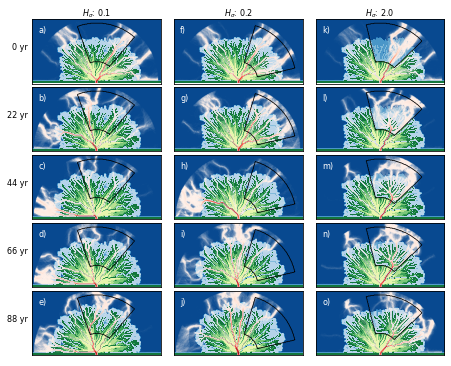

In [11]:
fig, ax = plt.subplots(5, 3, figsize=(7.5, 6.25), gridspec_kw={'hspace': 0.00, 'wspace': 0.05})

def make_selenga_column_from_cube(_icube, col):

    for i, t in enumerate([0, 15, 30, 45, 60]):
        # what is the time
        _t = scale_model_time(_icube.t[t]-_icube.t[0], If=If, units='years')

        # make the sigma contour
        _subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])
        ax[i, col].contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75)

        # make the correlation array
        selenga_corr = compute_connection_strength_array(_icube, t=t)

        # plot it all up
        cb = dm.plot.aerial_view(
            _icube['eta'][t, :, :],
            ax=ax[i, col], ticks=False,
            h=5, n=1.5)
        cb.remove()
        dm.plot.overlay_sparse_array(
            selenga_corr, ax=ax[i, col], alpha_clip=selenga_overlay_clip)

        _sig_rnd = np.round(np.array(_icube.meta['sigma']).max(), 2)
        if i ==0:
            ax[i, col].set_title(' '.join(("$H_\\sigma$:", str(_sig_rnd))),
                color='k', ha='center', fontsize=_label_fontsize, pad=4)
        ax[i, col].text(0.05, 0.8, _axes_letter_getter(i+(col*5)),
               fontsize=_label_fontsize,
               color='white', transform=ax[i, col].transAxes)
        
        if col == 0:
            ax[i, col].set_ylabel('{:.0f} yr'.format(_t), fontsize=_label_fontsize, ha='right', color='k', rotation=0)

make_selenga_column_from_cube(selenga_cubes[28], 0)
make_selenga_column_from_cube(selenga_cubes[38], 1)
make_selenga_column_from_cube(selenga_cubes[58], 2)
    
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/selenga_timeslice_demo.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/selenga_timeslice_demo.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


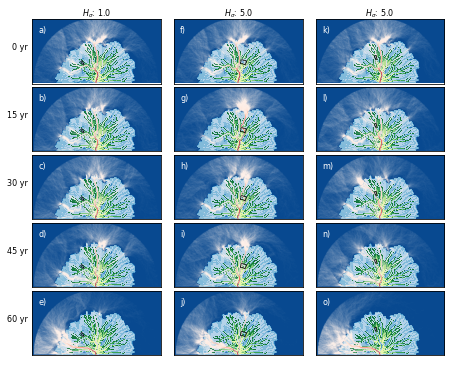

In [12]:
fig, ax = plt.subplots(5, 3, figsize=(7.5, 6.25), gridspec_kw={'hspace': 0.00, 'wspace': 0.05})

def make_mississippi_column_from_cube(_icube, col):

    for i, t in enumerate([0, 5, 10, 15, 20]):
        # what is the time
        _t = scale_model_time(_icube.t[t]-_icube.t[0], If=If, units='years')

        # make the sigma contour
        _subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])
        ax[i, col].contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75)

        # make the correlation array
        mississippi_corr = compute_connection_strength_array(_icube, t=t)

        # plot it all up
        cb = dm.plot.aerial_view(
            _icube['eta'][t, :, :],
            datum=_icube.meta['H_SL'][t],
            ax=ax[i, col], ticks=False,
            h=10, n=2)
        cb.remove()
        dm.plot.overlay_sparse_array(
            mississippi_corr, ax=ax[i, col], alpha_clip=mississippi_overlay_clip)

        _sig_rnd = np.round(np.array(_icube.meta['sigma']).max(), 2)
        if i ==0:
            ax[i, col].set_title(' '.join(("$H_\\sigma$:", str(_sig_rnd))),
                color='k', ha='center', fontsize=_label_fontsize, pad=4)
        
        ax[i, col].text(0.05, 0.8, _axes_letter_getter(i+(col*5)),
               fontsize=_label_fontsize,
               color='white', transform=ax[i, col].transAxes)
        
        if col == 0:
            ax[i, col].set_ylabel('{:.0f} yr'.format(_t), fontsize=_label_fontsize, ha='right', color='k', rotation=0)

make_mississippi_column_from_cube(mississippi_cubes[28], 0)
make_mississippi_column_from_cube(mississippi_cubes[58], 1)
make_mississippi_column_from_cube(mississippi_cubes[48], 2)
    
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_timeslice_demo.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_timeslice_demo.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

## load the datatables

Load the data tables from the process scripts, and make whatever modifications are necessary to get them ready for analysis plots.

These tables contain the full timeseries analysis for each simulation.

In [13]:
# categorize the subsided area
def _categorize_subsd_area(row):
    if row['subsd_area'] < 30e6:
        return 0
    elif row['subsd_area'] > 30e6 and row['subsd_area'] < 75e6:
        return 1
    else:
        return 2

# add columns to tables
def add_columns_to_tables(tbl):

    if 'subsd_avg_radius' in tbl.columns:
        tbl['block_ratio_radius'] = tbl['subsd_avg_radius'] / tbl['delta_avg_radius']
    
    if 'subsd_area' in tbl.columns:
        tbl['subsd_area_cat'] = tbl.apply(_categorize_subsd_area, axis=1)
    
    tbl['sigma_category'] = tbl['sigma'].astype('category').cat.codes

    return tbl

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# load the datatables

# load the set 1 / selenga set
selenga_meta = pd.read_csv(os.path.join('output_tables', 'set1_metasummary_table.csv'), index_col=0)
selenga_spinups = pd.read_csv(os.path.join('output_tables', 'set1_spinups_table.csv'), index_col=0)
selenga_spinups['sigma'] = 0  # apply a correction!
selenga_matrix = pd.read_csv(os.path.join('output_tables', 'set1_matrix_table.csv'), index_col=0)

# augment
selenga_spinups = add_columns_to_tables(selenga_spinups)
selenga_matrix = add_columns_to_tables(selenga_matrix)

# make the summary tables with means and stddevs
selenga_spinups_mean = selenga_spinups.groupby(['sigma', 'time']).mean().unstack(level=0)
selenga_spinups_stddev = selenga_spinups.groupby(['sigma', 'time']).std().unstack(level=0)
selenga_matrix_mean = selenga_matrix.groupby(['sigma', 'time']).mean().unstack(level=0)
selenga_matrix_stddev = selenga_matrix.groupby(['sigma', 'time']).std().unstack(level=0)

selenga_sigmas_columns_list = selenga_matrix_mean['delta_area'].columns



# load the set 2 / misssissippi set
mississippi_meta = pd.read_csv(os.path.join('output_tables', 'set2_metasummary_table.csv'), index_col=0)
mississippi_spinups = pd.read_csv(os.path.join('output_tables', 'set2_spinups_table.csv'), index_col=0)
mississippi_matrix = pd.read_csv(os.path.join('output_tables', 'set2_matrix_table.csv'), index_col=0)

# augment
mississippi_matrix = add_columns_to_tables(mississippi_matrix)

# make the summary tables with means and stddevs
mississippi_spinups_mean = mississippi_spinups.groupby(['time']).mean().unstack(level=0)
mississippi_spinups_stddev = mississippi_spinups.groupby(['time']).std().unstack(level=0)
mississippi_matrix_mean = mississippi_matrix.groupby(['sigma', 'time']).mean().unstack(level=0)
mississippi_matrix_stddev = mississippi_matrix.groupby(['sigma', 'time']).std().unstack(level=0)

mississippi_sigmas_columns_list = mississippi_matrix_mean['delta_area'].columns

Make an "early stage" and "late stage" Mississippi summary

In [15]:
# mississippi_early = mississippi_matrix.loc[mississippi_matrix['time_idx'] == 9]
# mississippi_late = mississippi_matrix.loc[mississippi_matrix['time_idx'] == 107]

We also need to process some metadata to summarize each run of the simulations with one data point.

In [16]:
# make an expanded metadata summary table
selenga_summary = selenga_meta.copy()

# precompute required attrs
selenga_spinup_OAP = dm.plan.OpeningAnglePlanform.from_elevation_data(
    selenga_SPINUPS_SAMPLE['eta'][-1, :, :],
    elevation_threshold=0)
selenga_spinup_landmask = dm.mask.LandMask.from_OAP(selenga_spinup_OAP)  # where was land in spinup
selenga_spinup_shoremask = dm.mask.ShorelineMask.from_OAP(selenga_spinup_OAP)
selenga_spinup_area = (float(np.sum(selenga_spinup_landmask.mask)) * (float(selenga_SPINUPS_SAMPLE.meta.dx.values))**2) # what is the total land area of the topset in spinup

# make an expanded metadata summary table
mississippi_summary = selenga_meta.copy()

# precompute required attrs
mississippi_spinup_OAP = dm.plan.OpeningAnglePlanform.from_elevation_data(
    mississippi_SPINUPS_SAMPLE['eta'][-1, :, :],
    elevation_threshold=mississippi_SPINUPS_SAMPLE.meta['H_SL'][-1])
mississippi_spinup_landmask = dm.mask.LandMask.from_OAP(mississippi_spinup_OAP)  # where was land in spinup
mississippi_spinup_shoremask = dm.mask.ShorelineMask.from_OAP(mississippi_spinup_OAP)  # where was land in spinup
mississippi_spinup_area = (float(np.sum(mississippi_spinup_landmask.mask)) * (float(mississippi_SPINUPS_SAMPLE.meta.dx.values))**2) # what is the total land area of the topset in spinup

In [17]:
def _get_background_range_meanstddev(var, mean_table, stddev_table):
    
    _columns_list = mean_table['delta_area'].columns
    
    _low = mean_table[var][_columns_list[0]] - stddev_table[var][_columns_list[0]]
    _high = mean_table[var][_columns_list[0]] + stddev_table[var][_columns_list[0]]
        
    return _low.values, _high.values


/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
selenga_summary = selenga_meta.copy()

# preallocate columns in datatable
selenga_summary['subsd_land_area'] = np.nan
selenga_summary['sigma_star_delta'] = np.nan
selenga_summary['sigma_star_channel'] = np.nan
selenga_summary['Diff_C'] = np.nan

# loop through each cube and make the entries
_start_time = scale_model_time(selenga_CUBES_SAMPLE.t[0], If=If, units='years')
for i, (mcube, mpth, mid) in enumerate(zip(selenga_cubes, selenga_summary.index, selenga_matrix['ID'].unique())):
    matrix_ID = selenga_matrix[selenga_matrix['ID'] == mid]
    mcube_sigma = mcube.meta['sigma'] != 0
    _subsd_land = np.logical_and(mcube_sigma, selenga_spinup_landmask.mask)  # intersection
    _subsd_area = (float(np.sum(_subsd_land)) * (float(mcube.meta.dx.values))**2)
    _delta_volume = (selenga_spinup_area * float(selenga_meta['Hbf'][i]))
    _delta_radius, _ = dm.plan.compute_shoreline_distance(
        selenga_spinup_shoremask, origin=[mcube.meta['CTR'].data, mcube.meta['L0'].data])
    _delta_channel_volume = _delta_radius * float(selenga_meta['Hbf'][i]) * mcube.meta.dx.data
    _sigma_star_delta = (_subsd_area * float(selenga_meta['sigma'][i])) / _delta_volume
    _sigma_star = (0.33 * (float(selenga_meta['sigma'].values[i]) / float(selenga_meta['Hbf'].values[i])))
    _sigma_star_channel = 0.15241894791723032 * ((.33 * (3.14 * 40 * 150)) / (463.90872965)) * (float(selenga_meta['sigma'].values[i]) / 2.385701755682627)
    
    # metadata
    selenga_summary['subsd_land_area'].loc[mpth] = _subsd_area
    selenga_summary['sigma_star_delta'].loc[mpth] = _sigma_star_delta
    selenga_summary['sigma_star_channel'].loc[mpth] = _sigma_star_channel
    selenga_summary['Diff_C'].loc[mpth] = matrix_ID['flux_sed_diff_c'].values[1:4].mean()
    
selenga_summary['sigma_category'] = selenga_summary['sigma'].astype('category')

In [49]:
# make a table summarizing the fulled-ness of the various runs, and when they receive sediment, and their connectivity
mississippi_summary = mississippi_meta.copy()

mississippi_summary['when_getsed'] = np.nan
mississippi_summary['is_filled'] = np.nan
mississippi_summary['when_filled'] = np.nan
mississippi_summary['dur_filling'] = np.nan
mississippi_summary['connect_metric'] = np.nan
mississippi_summary['subsd_land_area'] = np.nan
mississippi_summary['sigma_star_delta'] = np.nan
mississippi_summary['sigma_star_channel'] = np.nan
mississippi_summary['is_connected'] = np.nan
mississippi_summary['Diff_C'] = np.nan
mississippi_summary['flux_when_getsed'] = np.nan


_filled_check = 0.90
_thresh_connect = 0.05
for i, (mcube, mpth, mid) in enumerate(zip(mississippi_cubes, mississippi_meta.index, mississippi_matrix['ID'].unique())):
    matrix_ID = mississippi_matrix[mississippi_matrix['ID'] == mid]
    _frac_filled = matrix_ID['sediment_accum'] / (matrix_ID['subsd_area'] * matrix_ID['sigma'])

    _getsed_idx = np.argmax(_frac_filled >= 0.05)
    mississippi_summary['when_getsed'].loc[mpth] = matrix_ID['time'].values[_getsed_idx]
    mississippi_summary['is_filled'].loc[mpth] = int(np.any(_frac_filled >= _filled_check))
    if mississippi_summary['is_filled'].loc[mpth]:
        mississippi_summary['when_filled'].loc[mpth] = matrix_ID['time'].values[np.argmax(_frac_filled >= _filled_check)]
        mississippi_summary['dur_filling'].loc[mpth] = mississippi_summary['when_filled'].loc[mpth] - mississippi_summary['when_getsed'].loc[mpth]
    mississippi_summary['connect_metric'].loc[mpth] = matrix_ID['subsd_connectivity_max0'].max()
    mississippi_summary['Diff_C'].loc[mpth] = matrix_ID['flux_sed_diff_c'].values[0:3].mean()

    if _getsed_idx < len(matrix_ID)-1:
        mississippi_summary['flux_when_getsed'].loc[mpth] = matrix_ID['sediment_diff'].values[_getsed_idx+1] / (matrix_ID['time'].values[_getsed_idx+1] - matrix_ID['time'].index[_getsed_idx])
    
    _is_connected = matrix_ID['subsd_connectivity_max0'].max() > _thresh_connect
    mississippi_summary['is_connected'].loc[mpth] = int(_is_connected)
    
    mcube_sigma = mcube.meta['sigma'] != 0
    _subsd_land = np.logical_and(mcube_sigma, mississippi_spinup_landmask.mask)  # intersection
    _subsd_area = (float(np.sum(_subsd_land)) * (float(mcube.meta.dx.values))**2)
    mississippi_summary['subsd_land_area'].loc[mpth] = _subsd_area
    
    _delta_volume = (mississippi_spinup_area * float(mississippi_meta['Hbf'][i]))
    _delta_radius, _ = dm.plan.compute_shoreline_distance(
        mississippi_spinup_shoremask, origin=[mcube.meta['CTR'].data, mcube.meta['L0'].data])
    _delta_channel_volume = _delta_radius * float(mississippi_meta['Hbf'][i]) * mcube.meta.dx.data
    
    _arc_frac = mississippi_meta['subsd_width'][i] / (float(mississippi_meta['subsd_radius1'][i]) * mcube.meta.dx.data * np.pi)
    _sigma_star = (_arc_frac * (float(mississippi_meta['sigma'].values[i]) / float(mississippi_meta['Hbf'].values[i])))
    _sigma_star_delta = (_subsd_area * float(mississippi_meta['sigma'][i])) / _delta_volume
    _sigma_star_channel = 0.08386415658539154* (mississippi_meta['subsd_width'][i] / (2780.3300858899097)) * (float(mississippi_meta['sigma'].values[i]) / 5.925632476806641)
    mississippi_summary['sigma_star_delta'].loc[mpth] = _sigma_star_delta
    mississippi_summary['sigma_star_channel'].loc[mpth] = _sigma_star_channel

    
mississippi_summary['sigma_category'] = mississippi_summary['sigma'].astype('category')
mississippi_summary['width_category'] = pd.cut(mississippi_summary['subsd_width'], [2240, 2260, 7400, 7800, 14000, 16000]).astype('category')
mississippi_summary['replicate_category'] = mississippi_summary.groupby(['sigma_category', 'width_category'], sort=False).ngroup() + 1

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Simulation sets

Make a summary for some statistics about the simulations.

Here, we describe the width and area for subsided blocks in the various simulations.

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


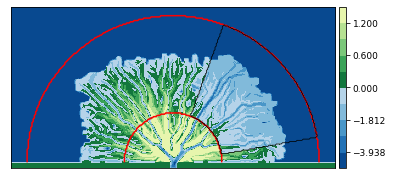

Subsided block width: 6586.16 m, of total arc length 19958.07 m
Subsided block length: 12000.00 m
Subsided block distance from inlet: 6003.4 +- 113.2 m


In [22]:
# what is the subsided block width and length of the Set 1 simulations?

# get a cube and some meta about it
_icube = selenga_cubes[55]
_subsd_mask = utilities._hacky_make_mask(_icube.meta['sigma'])

# make a proximal and distal section
_proximal_section = dm.section.CircularSection(_icube, radius=40)
_distal_section = dm.section.CircularSection(_icube, radius=120)

fig, ax = plt.subplots()
_proximal_section.show_trace('r-', ax=ax)
_distal_section.show_trace('r-', ax=ax)
ax.contour(_subsd_mask, levels=[0.5], colors='k', linewidths=0.75, zorder=3)
cb = dm.plot.aerial_view(
    _icube['eta'][0, :, :],
    ax=ax, ticks=False, h=5, n=1.5)
plt.show()

# proximal: get the width (section length), multiply by 1/3
_width = _proximal_section.s[-1] * _icube.meta.dx.data
print('Subsided block width: {:.2f} m, of total arc length {:.2f} m'.format(
    _width*0.33, _width))

# distal: get the distance between the proximal and distal sections
_len = (_distal_section.radius - _proximal_section.radius) * _icube.meta.dx.data
print('Subsided block length: {:.2f} m'.format(_len))

# compute distance to the subsided block
_dist = np.sqrt((_proximal_section.trace[:,0] - _icube.meta['CTR'].data)**2 + (_proximal_section.trace[:,1] - _icube.meta['L0'].data)**2) * _icube.meta.dx.data
print('Subsided block distance from inlet: {:.1f} +- {:.1f} m'.format(
    np.mean(_dist), np.std(_dist)))


In [23]:
# what is the input water discharge and input sediment discharge?

def _compute_Qw_Qs_from_meta(meta):
    _Qw = np.array(meta['h0'] * meta['u0'] * meta['N0'] * meta['dx'])
    _Qs = np.array(_Qw * (meta['C0_percent']/100))
    
    return _Qw[0], _Qs[0]

_selenga_Qw_Qs = _compute_Qw_Qs_from_meta(selenga_SPINUPS_SAMPLE.meta)
_mississippi_Qw_Qs = _compute_Qw_Qs_from_meta(mississippi_SPINUPS_SAMPLE.meta)

print('Selenga, Qw: {:.1f}, Qs: {:.1f}'.format(_selenga_Qw_Qs[0], _selenga_Qw_Qs[1]))
print('Mississippi, Qw: {:.1f}, Qs: {:.1f}'.format(_mississippi_Qw_Qs[0], _mississippi_Qw_Qs[1]))

Selenga, Qw: 4125.0, Qs: 4.1
Mississippi, Qw: 33750.0, Qs: 67.5


/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## What are the results for the paper?

In [24]:
def _plot_background_set(spinups, spinups_mean, spinups_stddev, matrix_mean, matrix_stddev, column_list, var, ax, apply_func=lambda x: x):

    # the range over the spinup, as filled timeseries
    ax.fill_between(
        (spinups_mean[var].index.values) - (spinups_mean[var].index.values[-1]),
        apply_func(spinups_mean[var][0] - spinups_stddev[var][0]),
        apply_func(spinups_mean[var][0] + spinups_stddev[var][0]),
        color=bg_color)
    # the range over the matrix with slip 0, as filled timeseries
    ax.fill_between(
        (matrix_mean[var][column_list[0]].index.values) - (matrix_mean[var][column_list[0]].index.values[0]),
        apply_func(matrix_mean[var][column_list[0]] - matrix_stddev[var][column_list[0]]),
        apply_func(matrix_mean[var][column_list[0]] + matrix_stddev[var][column_list[0]]),
        color=bg_color)
    # the mean and std of spin-up, as single mean std
    _mn = spinups[spinups['time'] > 200][var].mean()
    _std = spinups[spinups['time'] > 200][var].std()
    _markercolor = str(float(bg_color)*0.7)
    _markercolor = 'palevioletred'

In [25]:
def _plot_breakline(time, ylim, ax):
    ax.plot([time, time], [ylim[0], ylim[1]], 'k--', lw=2)

def _append_colorbar(fig, cm, labels, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    labels = np.round(np.array(labels), 2)

    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=0.5, vmax=len(labels)+0.5))

    norm = matplotlib.colors.BoundaryNorm(np.arange(cm.N+1)-0.5+1, cm.N)
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cm)
    sm.set_array([])

    formatter = plt.FuncFormatter(lambda val, loc: labels[val-1])

    divider = axtk.axes_divider.make_axes_locatable(ax)
    cax = divider.append_axes("right", size=str(2)+"%", pad=0.05)

    if len(labels) <= 10:
        cb = fig.colorbar(sm, cax=cax, ticks=np.arange(len(labels)+1), format=formatter)
    else:
        cb = fig.colorbar(sm, cax=cax, ticks=np.arange(len(labels)+1, step=5), format=formatter)
    _labelsize = kwargs.pop('labelsize', _colorbar_tick_fontsize)
    cb.ax.tick_params(labelsize=_labelsize)
    cb.ax.set_ylabel('displacement length $H_\\sigma$ (m)', fontsize=_colorbar_tick_fontsize)

    
def _hack_axis_labels(_ax, factor=1):
    _ax.xaxis.set_tick_params(labelsize=_tick_fontsize*factor)
    _ax.yaxis.set_tick_params(labelsize=_tick_fontsize*factor)
    _ax.xaxis.label.set_size(_label_fontsize*factor)
    _ax.yaxis.label.set_size(_label_fontsize*factor)

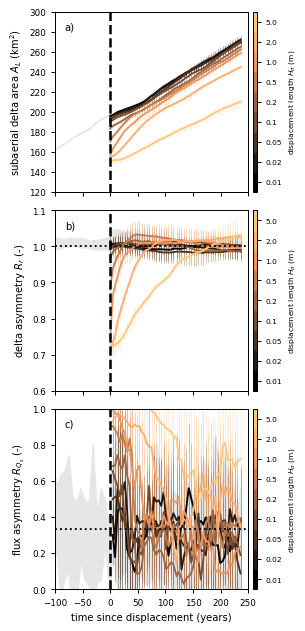

In [26]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(2.8, 8.5), dpi=DPI, gridspec_kw={'left': 0.1, 'hspace': 0.1}) # was (3,6)

# xaxis
xaxis_array = (selenga_matrix_mean['block_ratio_radius'][0].index.values) - (selenga_matrix_mean['block_ratio_radius'][0].index.values[0])


# TOP PLOT FOR A_L RATIO
for c, col in enumerate(selenga_sigmas_columns_list[1:]):
    cidx = c
    ax[0].plot(xaxis_array, selenga_matrix_mean['subaerial_area'][col] / 1e6, '-', color=selenga_cube_cm(cidx))
    ax[0].errorbar(
        xaxis_array,
        selenga_matrix_mean['subaerial_area'][col] / 1e6,
        selenga_matrix_stddev['subaerial_area'][col] / 1e6, color=selenga_cube_cm(cidx), ls='none', alpha=error_alpha, lw=0.75)
_plot_background_set(
    selenga_spinups,
    selenga_spinups_mean,
    selenga_spinups_stddev,
    selenga_matrix_mean,
    selenga_matrix_stddev,
    selenga_sigmas_columns_list,
    'subaerial_area',
    apply_func=lambda x: x / 1e6,
    ax=ax[0])

# prettify the plot
_plot_breakline(0, (0, 300), ax=ax[0])
_append_colorbar(fig, selenga_cube_cm, selenga_sigmas_columns_list[1:], ax=ax[0], labelsize=6)
_hack_axis_labels(ax[0])

# # labels and limits
ax[0].set_ylabel('subaerial delta area $A_L$ (km$^2$)')
ax[0].set_ylim(120, 300)
ax[0].set_xlim(selenga_t_lim)


# MIDDLE PLOT FOR R RATIO
for c, col in enumerate(selenga_sigmas_columns_list[1:]):
    cidx = c
    ax[1].plot(xaxis_array, selenga_matrix_mean['block_ratio_radius'][col], '-', color=selenga_cube_cm(cidx))
    ax[1].errorbar(
        xaxis_array,
        selenga_matrix_mean['block_ratio_radius'][col],
        selenga_matrix_stddev['block_ratio_radius'][col], color=selenga_cube_cm(cidx), ls='none', alpha=error_alpha, lw=0.75)
_plot_background_set(
    selenga_spinups,
    selenga_spinups_mean,
    selenga_spinups_stddev,
    selenga_matrix_mean,
    selenga_matrix_stddev,
    selenga_sigmas_columns_list,
    'block_ratio_radius',
    ax=ax[1])

# prettify the plot
_plot_breakline(0, (0, 1.1), ax=ax[1])
_append_colorbar(fig, selenga_cube_cm, selenga_sigmas_columns_list[1:], ax=ax[1], labelsize=6)
_hack_axis_labels(ax[1])
ax[1].plot(selenga_t_lim, [1, 1], ls=':', c='k')

# labels and limits
ax[1].set_ylabel('delta asymmetry $R_r$ (-)')
ax[1].set_ylim(0.6, 1.1)

# plot an inset
_INSET = False
if _INSET:
    inax = ax[1].inset_axes([0.65, 0.175, 0.325, 0.3])
    xmax = 450
    inax.plot([0, xmax], [0, xmax], 'k-', zorder=0)
    inax.plot([0, xmax], [0, xmax/3], 'k-', zorder=0)
    _SF = scale_model_time(1, If, 'years')
    ss_mean = selenga_summary.groupby('sigma').mean()
    _exp = (ss_mean.index*ss_mean['subsd_land_area']) / ((ss_mean['Qs'] / _SF)*.33)
    _obs = ss_mean['block_ratio_radius_dur']
    inax.scatter(_exp.values, _obs.values,
    #            c=ss_mean['sigma_category'].index.astype('category').cat.codes,
               cmap=selenga_cube_cm)
    inax.set_xlim(0, xmax)
    inax.set_ylim(0, xmax)
    inax.set_xlabel('expected (years)')
    inax.set_ylabel('observed\n(years)')
    _hack_axis_labels(inax, factor=0.9)

    
# BOTTOM PLOT FOR WATER ASYMMETRY RATIO
for c, col in enumerate(selenga_sigmas_columns_list[1:]):
    cidx = c
    ax[2].plot(xaxis_array[1:], selenga_matrix_mean['flux_sed_frac_subsd'][col].values[1:], '-', color=selenga_cube_cm(cidx))
    ax[2].errorbar(
        xaxis_array[1:],
        selenga_matrix_mean['flux_sed_frac_subsd'][col].values[1:],
        selenga_matrix_stddev['flux_sed_frac_subsd'][col].values[1:], color=selenga_cube_cm(cidx), ls='none', alpha=error_alpha, lw=0.75)
_plot_background_set(
    selenga_spinups,
    selenga_spinups_mean,
    selenga_spinups_stddev,
    selenga_matrix_mean,
    selenga_matrix_stddev,
    selenga_sigmas_columns_list,
    'flux_sed_frac_subsd',
    ax=ax[2])

# prettify the plot
_plot_breakline(0, (0, 1.1), ax=ax[2])
_append_colorbar(fig, selenga_cube_cm, selenga_sigmas_columns_list[1:], ax=ax[2])
_hack_axis_labels(ax[2])
ax[2].plot(selenga_t_lim, [0.333333, 0.33333], ls=':', c='k')

# labels and limits
ax[2].set_ylabel('flux asymmetry $R_{Q_s}$ (-)')
ax[2].set_xlabel('time since displacement (years)')
ax[2].set_ylim(0, 1.0)
ax[0].set_xlim(selenga_t_lim)

for i, axi in enumerate(ax.ravel()):
    axi.text(0.05, 0.9, _axes_letter_getter(i),
             fontsize=_label_fontsize,
             color='k', transform=axi.transAxes)

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/selenga_selected_results.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/selenga_selected_results.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [27]:
def _adjust_bp_conn_style(bp_art):
    bp_art['boxes'][i].set_facecolor(dm.plot._scale_lightness(connect_colors[i], 1.4))
    bp_art['boxes'][i].set_edgecolor(connect_colors[i])
    for w, whisker in enumerate(bp_art['whiskers'][i*2:i*2+2]):
        whisker.set_color(connect_colors[i])
    for c, cap in enumerate(bp_art['caps'][i*2:i*2+2]):
        cap.set_color(connect_colors[i])
    bp_art['medians'][i].set_color(dm.plot._scale_lightness(connect_colors[i], 0.9))
    bp_art['medians'][i].set_linewidth(5)
    bp_art['fliers'][i].set_markeredgecolor(connect_colors[i])

t_base = mississippi_breakline_time

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


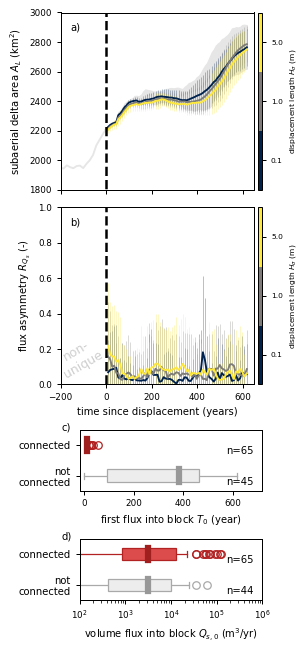

In [28]:
# make the area plot
fig = plt.figure(figsize=(2.8, 7.25), dpi=DPI)
# fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3, 6), dpi=DPI, gridspec_kw={'left': 0.1, 'hspace': 0.1})

# gridspecs
top_gs = fig.add_gridspec(nrows=2, ncols=1,
                      left=0.05, right=0.85,
                      bottom=0.38, top=0.95,
                      wspace=0.2, hspace=0.1)
bot_gs = fig.add_gridspec(nrows=2, ncols=1,
                      left=0.125, right=0.85,
                      bottom=0.05, top=0.31,
                      wspace=0.2, hspace=0.8)


# make the top axis
ax_top0 = fig.add_subplot(top_gs[0])
ax_top1 = fig.add_subplot(top_gs[1])

# xaxis
xaxis_array = (mississippi_matrix_mean['subaerial_area'][0].index.values) - (mississippi_matrix_mean['subaerial_area'][0].index.values[0])

# plot the lines
for c, col in enumerate(mississippi_sigmas_columns_list[1:]):
    cidx = c
    ax_top0.plot(xaxis_array, mississippi_matrix_mean['subaerial_area'][col] / 1e6, '-', color=mississippi_cube_cm(cidx))
    ax_top0.errorbar(
        xaxis_array,
        mississippi_matrix_mean['subaerial_area'][col] / 1e6,
        mississippi_matrix_stddev['subaerial_area'][col] / 1e6, color=mississippi_cube_cm(cidx), ls='none', alpha=error_alpha, lw=0.75)
    

ax_top0.plot(
    mississippi_spinups_mean['subaerial_area'].index.values - mississippi_spinups_mean['subaerial_area'].index.values[-1],
    mississippi_spinups_mean['subaerial_area'] / 1e6,
    '-', color=bg_color)

_plot_background_set(
    mississippi_spinups,
    mississippi_spinups_mean,
    mississippi_spinups_stddev,
    mississippi_matrix_mean,
    mississippi_matrix_stddev,
    mississippi_sigmas_columns_list,
    'subaerial_area',    # NEED TO GET THIS METRIC COMPUTED IN SPINUPS
    ax=ax_top0,
    apply_func=lambda x: x / 1e6)

# prettify the plot
_plot_breakline(0, (1000, 4000), ax=ax_top0)
_append_colorbar(fig, mississippi_cube_cm, mississippi_sigmas_columns_list[1:], ax=ax_top0)

# labels and limits
ax_top0.set_ylabel('subaerial delta area $A_L$ (km$^2$)')
ax_top0.set_xlim(mississippi_t_lim)
ax_top0.set_ylim(1800, 3000)
ax_top0.set_xticklabels([])
_hack_axis_labels(ax_top0)


# BOTTOM PLOT FOR WATER ASYMMETRY RATIO
for c, col in enumerate(mississippi_sigmas_columns_list[1:]):
    cidx = c
    ax_top1.plot(xaxis_array[1:], mississippi_matrix_mean['flux_sed_frac_subsd'][col].values[1:], '-', color=mississippi_cube_cm(cidx))
    ax_top1.errorbar(
        xaxis_array[1:],
        mississippi_matrix_mean['flux_sed_frac_subsd'][col].values[1:],
        mississippi_matrix_stddev['flux_sed_frac_subsd'][col].values[1:], color=mississippi_cube_cm(cidx), ls='none', alpha=error_alpha, lw=0.75)
# BACKGROUND SET IS NOT DEFINED FOR THE MISSISSIPPI CASES
#   The size of subsided block varies across expts so cannot compute
#   one curve for background set. It should be possible to compute 
#   a separate curve for each subsidence size.
ax_top1.text(0.1, 0.15, 'non-\nunique',
        color=dm.plot._scale_lightness((float(bg_color),) * 3, 0.9), rotation=30,
        ha='center', va='center',
        transform=ax_top1.transAxes)

# prettify the plot
_plot_breakline(0, (0, 1.1), ax=ax_top1)
_append_colorbar(fig, mississippi_cube_cm, mississippi_sigmas_columns_list[1:], ax=ax_top1)
_hack_axis_labels(ax_top1)

# labels and limits
ax_top1.set_ylabel('flux asymmetry $R_{Q_s}$ (-)')
ax_top1.set_xlabel('time since displacement (years)')
ax_top1.set_ylim(0, 1.0)

ax_top1.set_xlim(mississippi_t_lim)




# make the datatable
_bp_data_getsed = [mississippi_summary[~mississippi_summary['is_connected'].astype(bool)]['when_getsed'].dropna()-t_base,
                   mississippi_summary[mississippi_summary['is_connected'].astype(bool)]['when_getsed'].dropna()-t_base]

_bp_data_flux = [mississippi_summary[~mississippi_summary['is_connected'].astype(bool)]['flux_when_getsed'].dropna(),   # what is sediment aggradation rate at time when get sed
                   mississippi_summary[mississippi_summary['is_connected'].astype(bool)]['flux_when_getsed']]

_bp_data_filled = [mississippi_summary[~mississippi_summary['is_connected'].astype(bool)]['when_filled'].dropna()-t_base,
                   mississippi_summary[mississippi_summary['is_connected'].astype(bool)]['when_filled'].dropna()-t_base]

# make the bot axis
ax_bot0 = fig.add_subplot(bot_gs[0])
ax_bot1 = fig.add_subplot(bot_gs[1])

bp_art_0 = ax_bot0.boxplot(_bp_data_getsed, patch_artist=True, widths=0.4, vert=False)
bp_art_1 = ax_bot1.boxplot(_bp_data_flux, patch_artist=True, widths=0.4, vert=False)
# bp_art_2 = ax[2].boxplot(_bp_data_filled, patch_artist=True, widths=0.4)
for i in range(len(_bp_data_getsed)):
    # add a number of items label
    ax_bot0.text(0.8, i/2+0.1, 'n='+str(len(_bp_data_getsed[i])), transform=ax_bot0.transAxes, fontsize=_label_fontsize)
    ax_bot1.text(0.8, i/2+0.1, 'n='+str(len(_bp_data_flux[i])), transform=ax_bot1.transAxes, fontsize=_label_fontsize)
    pass
    
    # adjust the style
    _adjust_bp_conn_style(bp_art_0)
    _adjust_bp_conn_style(bp_art_1)

ax_bot1.set_xscale('log')
    
ax_bot0.set_xlim(-20, 720)
ax_bot1.set_xlim(1e2, 1e6)

# ax[0].set_ylim(0, )

# ax[1].yaxis.tick_right()
# ax[1].yaxis.set_label_position('right')
_hack_axis_labels(ax_bot0)
_hack_axis_labels(ax_bot1)
    
ticklabels = ['not\nconnected', 'connected']
ax_bot0.set_yticklabels(ticklabels, fontsize=_label_fontsize)
ax_bot1.set_yticklabels(ticklabels, fontsize=_label_fontsize)

ax_bot0.set_xlabel('first flux into block $T_0$ (year)', fontsize=_label_fontsize)
ax_bot1.set_xlabel('volume flux into block $Q_{s,0}$ (m$^3$/yr)', fontsize=_label_fontsize)


for i, axi in enumerate([ax_top0, ax_top1]):
    axi.text(0.05, 0.9, _axes_letter_getter(i),
             fontsize=_label_fontsize,
             color='k', transform=axi.transAxes)
    
for i, axi in enumerate([ax_bot0, ax_bot1]):
    axi.text(-0.1, 1, _axes_letter_getter(i+2),
             fontsize=_label_fontsize,
             color='k', transform=axi.transAxes)

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_selected_results.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_selected_results.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

plt.show()

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


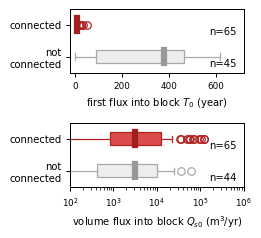

In [29]:
# filled by comparison plot



# make the plot
fig, ax = plt.subplots(2, 1, figsize=(3, 2.75), dpi=90)
bp_art_0 = ax[0].boxplot(_bp_data_getsed, patch_artist=True, widths=0.4, vert=False)
bp_art_1 = ax[1].boxplot(_bp_data_flux, patch_artist=True, widths=0.4, vert=False)
# bp_art_2 = ax[2].boxplot(_bp_data_filled, patch_artist=True, widths=0.4)
for i in range(len(_bp_data_getsed)):
    # add a number of items label
    ax[0].text(0.8, i/2+0.1, 'n='+str(len(_bp_data_getsed[i])), transform=ax[0].transAxes, fontsize=_label_fontsize)
    ax[1].text(0.8, i/2+0.1, 'n='+str(len(_bp_data_flux[i])), transform=ax[1].transAxes, fontsize=_label_fontsize)
    pass
    
    # adjust the style
    _adjust_bp_conn_style(bp_art_0)
    _adjust_bp_conn_style(bp_art_1)

ax[1].set_xscale('log')
    
ax[0].set_xlim(-20, 720)
ax[1].set_xlim(1e2, 1e6)

# ax[0].set_ylim(0, )

# ax[1].yaxis.tick_right()
# ax[1].yaxis.set_label_position('right')
_hack_axis_labels(ax[0])
_hack_axis_labels(ax[1])
    
ticklabels = ['not\nconnected', 'connected']
ax[0].set_yticklabels(ticklabels, fontsize=_label_fontsize)
ax[1].set_yticklabels(ticklabels, fontsize=_label_fontsize)

ax[0].set_xlabel('first flux into block $T_0$ (year)', fontsize=_label_fontsize)
ax[1].set_xlabel('volume flux into block $Q_{s0}$ (m$^3$/yr)', fontsize=_label_fontsize)



plt.tight_layout()

# fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_connect_getsed.png', dpi=200, bbox_inches='tight', pad_inches=0)
# fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_connect_getsed.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

In [30]:
# do the statistical tests here
_getset_ttest = weightstats.ttest_ind(_bp_data_getsed[0], _bp_data_getsed[1], usevar='unequal')
_sedflux_ttest = weightstats.ttest_ind(_bp_data_flux[0], _bp_data_flux[1], usevar='unequal')

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# print out some summary information about the data and stat tests
print('Timing, connected:\n median: {:.0f}, mean: {:.0f}'.format(
    np.median(_bp_data_getsed[1]), np.mean(_bp_data_getsed[1]))
    )
print('Timing, not connected:\n median: {:.0f}, mean: {:.0f}'.format(
    np.median(_bp_data_getsed[0]), np.mean(_bp_data_getsed[0]))
    )
print('Timing, statistical difference: {:.1e}'.format(
    _getset_ttest[1])
    )
print('Flux, statistical difference: {:.1e}, test statistic: {:.1e}'.format(
    _sedflux_ttest[1], _sedflux_ttest[0])
    )

Timing, connected:
 median: 9, mean: 11
Timing, not connected:
 median: 381, mean: 310
Timing, statistical difference: 7.0e-13
Flux, statistical difference: 4.2e-02, test statistic: -2.1e+00


## Bring it all together figure

Need one or two figures that I can plot my numerical results and the field examples on. This needs to be non-dimensionalized!

In [32]:
def _get_background_range(var, bg_set):
    if bg_set == 'minmax':
        _low = matrix_min_table[var][_column_list[0]]
        _high = matrix_max_table[var][_column_list[0]]
    elif bg_set == 'meanstd':
        _low = matrix_mean_table[var][_column_list[0]] - matrix_stddev_table[var][_column_list[0]]
        _high = matrix_mean_table[var][_column_list[0]] + matrix_stddev_table[var][_column_list[0]]
    elif bg_set == 'single':
        if len(SPINUPS) > 1:
            raise NotImplementedError
        else:
            # the mean and std of spin-up, fixed over time
            _mn = spinups[spinups['time'] > 500][var].mean()
            _std = spinups[spinups['time'] > 500][var].std()
            _low = _mn - _std
            _high = _mn + _std
            return _low, _high
    else:
        raise ValueError
        
    return _low.values, _high.values

In [33]:
# split the mississippi data into sets of connected and not connected

# connected
_miss_conn = mississippi_summary.loc[mississippi_summary['is_connected'].astype(bool)]
_miss_conn = _miss_conn[_miss_conn['sigma'] > 0]

# not connected
_miss_notconn = mississippi_summary.loc[~mississippi_summary['is_connected'].astype(bool)]
_miss_notconn = _miss_notconn[_miss_notconn['sigma'] > 0]

In [34]:
# import the field observation data

# open the table as a df and grab the computed values
#   WARNING: indicices are hard coded and will break if sheet is changed
df = pd.read_excel (os.path.join('_analysis', 'realworld_measurements.ods'))
locs = df['Unnamed: 11'].values[4:7]
mins = df['Unnamed: 12'].values[4:7]
maxs = df['Unnamed: 13'].values[4:7]

field_sigma_star = pd.DataFrame(
    data={'name': locs,
          'min': mins,
          'max': maxs,
          'ys': [-0.12, -0.12, -0.15],
          'offs': [0.25, 0.185, 1.6]})
field_sigma_star

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,name,min,max,ys,offs
0,"Mississippi River delta, Cubit’s Gap",0.225508,1.387329,-0.12,0.250
1,"Mississippi River delta, main channel",0.005105,0.009119,-0.12,0.185
2,Selenga River delta,1.039774,21.096596,-0.15,1.600


/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


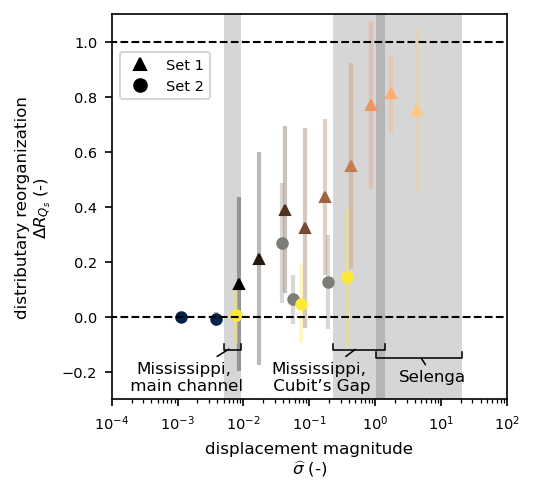

In [35]:
fig, ax = plt.subplots(figsize=(3.4, 3.4), dpi=150)

selenga_mean_sigma_star_delta = selenga_summary.groupby(['sigma_star_channel']).mean()['sigma_star_delta']
selenga_mean_diffC = selenga_summary.groupby(['sigma_star_channel']).mean()['Diff_C']
selenga_stdev_diffC = selenga_summary.groupby(['sigma_star_channel']).std()['Diff_C']

for i, sigidx in enumerate(np.arange(1, len(selenga_mean_diffC))):
    cidx = i
    ax.plot(
        selenga_mean_diffC.index[sigidx],
#         selenga_mean_sigma_star_channel.values[sigidx],
        selenga_mean_diffC.iloc[sigidx],
        marker='^', markersize=5,
        color=selenga_cube_cm(cidx))
    ax.errorbar(
        selenga_mean_diffC.index[sigidx],
        selenga_mean_diffC.iloc[sigidx],
        selenga_stdev_diffC.iloc[sigidx],
        color=selenga_cube_cm(cidx),
        ls='none', marker=None,
        alpha=error_alpha,
        lw=2)
    
mississippi_mean_sigma_star_channel = _miss_conn.groupby(['replicate_category']).mean()['sigma_star_channel']
mississippi_mean_diffC = _miss_conn.groupby(['replicate_category']).mean()['Diff_C']
mississippi_stdev_diffC = _miss_conn.groupby(['replicate_category']).std()['Diff_C']

for i, sigidx in enumerate(np.arange(0, len(mississippi_mean_diffC))):
    cidx = (mississippi_mean_diffC.index[i]-1) // 3
    ax.plot(
        mississippi_mean_sigma_star_channel.values[sigidx],
        mississippi_mean_diffC.iloc[sigidx],
        marker='o', markersize=5,
        color=mississippi_cube_cm(cidx))
    ax.errorbar(
        mississippi_mean_sigma_star_channel.values[sigidx],
        mississippi_mean_diffC.iloc[sigidx],
        mississippi_stdev_diffC.iloc[sigidx],
        color=mississippi_cube_cm(cidx),
        ls='none', marker=None,
        alpha=error_alpha,
        lw=2)

def plot_bracket(x0,x1,y,off,label):
    yo = 0.02
    ax.plot([x0, x0, x1, x1],
            [y+yo, y, y, y+yo],
           color='k', lw=0.75)
    logdist = np.log10(x0) + np.log10(x1)
    midpoint = 10**((logdist)/2)
    label = label.replace(',', ',\n')
    label = label.replace(' River delta', '')
    ax.annotate(
        label, xy=(midpoint, y+0.01),
        xytext=(midpoint*off, y-0.04), textcoords='data',
        ha='center', va='top', fontsize=_label_fontsize,
        arrowprops=dict(
            arrowstyle="-",
            lw=0.75, ec="k", shrinkA=-500))

# add the field data
for i, row in field_sigma_star.iterrows():
    # plot the fill
    ax.fill_between(
        [row['min'], row['max']], y1=-2, y2=2,
        color='0.2', alpha=0.2, edgecolor='none',
        zorder=0)
    
    # plot the bounding brackets
    plot_bracket(row['min'], row['max'], row['ys'], row['offs'], row['name'])
    
# make a fake legend
ax.plot(np.nan, np.nan, marker='^', ls='none', color='k', label='Set 1') # selenga_cube_cm(0)
ax.plot(np.nan, np.nan, marker='o', ls='none', color='k', label='Set 2') # mississippi_cube_cm(0)
ax.legend(fontsize=_tick_fontsize, loc=(0.02, 0.78))

# plot the metric limits
ax.plot([1e-8, 1e2], [1, 1], 'k--', lw=1)
ax.plot([1e-8, 1e2], [0, 0], 'k--', lw=1)
ax.plot([1e-8, 1e2], [-1, -1], 'k--', lw=1)

ax.set_xscale('log')
ax.set_xlim(1e-4, 1e2)
ax.set_ylim(-0.3, 1.1)

ax.set_ylabel('distributary reorganization\n$\\Delta R_{Q_s}$ (-)')
ax.set_xlabel('displacement magnitude\n$\\widehat{\\sigma}$ (-)')

_hack_axis_labels(ax)

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/summary_selected.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/summary_selected.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

# Supplementary information figures

In [43]:
# show the workflow to compute the main metrics in the paper
_cube = selenga_cubes[49]

# make a landmask for this set
_OAP = dm.plan.OpeningAnglePlanform.from_elevation_data(
    _cube['eta'][0, :, :],
    elevation_threshold=0)

_lm = dm.mask.LandMask.from_OAP(
    _OAP)

_sm = dm.mask.ShorelineMask.from_OAP(
    _OAP)
_sm.trim_mask(length=6)

_em = dm.mask.ElevationMask(
    _cube['eta'][0, :, :],
    elevation_threshold=0)

_subsd_mask = _cube.meta['sigma'] != 0

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


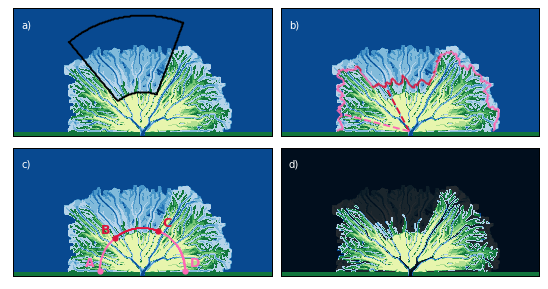

In [44]:
fig, ax = plt.subplots(2, 2, dpi=DPI, figsize=(6.3, 3.4), gridspec_kw={'wspace': 0, 'hspace': 0})

_, 
_, _shoreline_in = dm.plan.compute_shoreline_length(np.logical_and(_sm.mask, np.array(_subsd_mask)), return_line=True)

for axi in ax.ravel():
    cb = dm.plot.aerial_view(_cube['eta'][0, :, :], datum=0, ax=axi, ticks=False)
    cb.remove()

# starting point
ax[0, 0].contour(_subsd_mask, levels=[0.95], colors='k')

# shoreline
# split and make two colors
_in_shoremask = np.logical_and(_sm.mask, _subsd_mask)
_out_shoremask = np.logical_and(_sm.mask, ~_subsd_mask)
# _in_shoreline = dm.plan.compute_shoreline_length(_in_shoremask, return_line=True)
_in_whr_y, _in_whr_x = np.where(_in_shoremask)
_out_whr_y, _out_whr_x = np.where(_out_shoremask)
ax[0, 1].plot(_out_whr_x, _out_whr_y, '.', markersize=1, color='hotpink')
ax[0, 1].plot(_in_whr_x, _in_whr_y, '.', markersize=1, color='crimson')
ax[0, 1].plot([_cube.meta['CTR'].data, _in_whr_x[10]], [_cube.meta['L0'].data, _in_whr_y[10]], '--', color='crimson')
ax[0, 1].plot([_cube.meta['CTR'].data, _out_whr_x[40]], [_cube.meta['L0'].data, _out_whr_y[40]], '--', color='hotpink')

# flux
# split and make two colors
flux_section = dm.section.CircularSection(_cube, radius=44)
x, = np.where(np.array(_subsd_mask, dtype=int).flatten() != 0)
flat_trace = np.ravel_multi_index(
    np.flipud(flux_section.trace.T), _cube.shape[1:])
_match = np.isin(flat_trace, x)
# register split sections
flux_subsd = dm.section.PathSection(
    _cube, path=flux_section.trace[_match, :])
flux_total = dm.section.PathSection(
    _cube, path=flux_section.trace)
flux_total.show_trace(ax=ax[1, 0], color='hotpink')
flux_subsd.show_trace(ax=ax[1, 0], color='crimson')
ax[1, 0].plot(flux_total._x[0], flux_total._y[0], 'o', markersize=4, color='hotpink')
ax[1, 0].plot(flux_total._x[-1], flux_total._y[0], 'o', markersize=4, color='hotpink')
ax[1, 0].plot(flux_subsd._x[0], flux_subsd._y[0], 'o', markersize=4, color='crimson')
ax[1, 0].plot(flux_subsd._x[-1], flux_subsd._y[-1], 'o', markersize=4, color='crimson')
ax[1, 0].text(flux_total._x[0]-15, flux_total._y[0]+5, 'A', color='hotpink', fontweight='bold')
ax[1, 0].text(flux_total._x[-1]+5, flux_total._y[0]+5, 'D', color='hotpink', fontweight='bold')
ax[1, 0].text(flux_subsd._x[0]-15, flux_subsd._y[0]+5, 'B', color='crimson', fontweight='bold')
ax[1, 0].text(flux_subsd._x[-1]+5, flux_subsd._y[-1]+5, 'C', color='crimson', fontweight='bold')

# subaerial area
# transparent mask
_em_vis = np.copy(_em.mask).astype(float)
_em_vis[_em_vis == 1] = np.nan
ax[1, 1].imshow(_em_vis, cmap='Greys_r', alpha=0.8, origin='lower')
    
for axi in ax.ravel():
    axi.set_xlim(_cube.x[0], _cube.x[-1])
    axi.set_ylim(_cube.y[0], _cube.y[-1])
    
for i, axi in enumerate(ax.ravel()):
    axi.text(0.03, 0.85, _axes_letter_getter(i),
             fontsize=_label_fontsize,
             color='w', transform=axi.transAxes)

plt.tight_layout()

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/methods_demonstration.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/methods_demonstration.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    
plt.show()

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


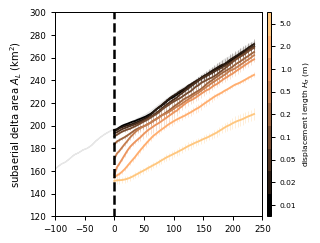

In [45]:
# compute the delta area for the selenga case
fig, ax = plt.subplots(figsize=(3, 3), dpi=DPI, gridspec_kw={'left': 0.1, 'hspace': 0.1})

# xaxis
xaxis_array = (selenga_matrix_mean['subaerial_area'][0].index.values) - (selenga_matrix_mean['subaerial_area'][0].index.values[0])

# TOP PLOT FOR R RATIO
for c, col in enumerate(selenga_sigmas_columns_list[1:]):
    cidx = c
    ax.plot(xaxis_array, selenga_matrix_mean['subaerial_area'][col] / 1e6, '-', color=selenga_cube_cm(cidx))
    ax.errorbar(
        xaxis_array,
        selenga_matrix_mean['subaerial_area'][col] / 1e6,
        selenga_matrix_stddev['subaerial_area'][col] / 1e6, color=selenga_cube_cm(cidx), ls='none', alpha=error_alpha, lw=0.75)
_plot_background_set(
    selenga_spinups,
    selenga_spinups_mean,
    selenga_spinups_stddev,
    selenga_matrix_mean,
    selenga_matrix_stddev,
    selenga_sigmas_columns_list,
    'subaerial_area',
    apply_func=lambda x: x / 1e6,
    ax=ax)

# prettify the plot
_plot_breakline(0, (0, 300), ax=ax)
_append_colorbar(fig, selenga_cube_cm, selenga_sigmas_columns_list[1:], ax=ax, labelsize=6)
_hack_axis_labels(ax)

# # labels and limits
ax.set_ylabel('subaerial delta area $A_L$ (km$^2$)')
ax.set_ylim(120, 300)
ax.set_xlim(selenga_t_lim)

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/selenga_supp_results.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/selenga_supp_results.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

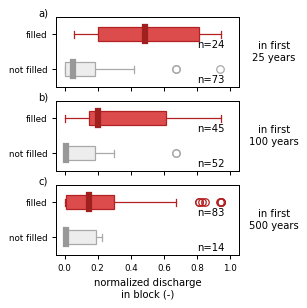

In [47]:
# connected vs filled? box plot
_bp_data_early = [mississippi_summary[mississippi_summary['when_filled']>2025]['connect_metric'].dropna(),
                 mississippi_summary[mississippi_summary['when_filled']<=2025]['connect_metric'].dropna()]
_bp_data_mid = [mississippi_summary[mississippi_summary['when_filled']>2100]['connect_metric'].dropna(),
                 mississippi_summary[mississippi_summary['when_filled']<=2100]['connect_metric'].dropna()]
_bp_data_later = [mississippi_summary[mississippi_summary['when_filled']>2500]['connect_metric'].dropna(),
                 mississippi_summary[mississippi_summary['when_filled']<=2500]['connect_metric'].dropna()]


# make the plot
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(3, 3.5), dpi=90, gridspec_kw={'right': 0.8})
bp_art_0 = ax[0].boxplot(_bp_data_early, patch_artist=True, widths=0.4, vert=False)
bp_art_1 = ax[1].boxplot(_bp_data_mid, patch_artist=True, widths=0.4, vert=False)
bp_art_2 = ax[2].boxplot(_bp_data_later, patch_artist=True, widths=0.4, vert=False)
for i in range(len(_bp_data_early)):
    # add a number of items label
    ax[0].text(0.8, i+1-0.4, 'n='+str(len(_bp_data_early[i])), fontsize=_label_fontsize)
    ax[1].text(0.8, i+1-0.4, 'n='+str(len(_bp_data_mid[i])), fontsize=_label_fontsize)
    ax[2].text(0.8, i+1-0.4, 'n='+str(len(_bp_data_later[i])), fontsize=_label_fontsize)
    
    # adjust the style
    _adjust_bp_conn_style(bp_art_0)
    _adjust_bp_conn_style(bp_art_1)
    _adjust_bp_conn_style(bp_art_2)
    pass

ax[0].set_xlim(-0.05, 1.05)
    
ticklabels = ['not filled', 'filled']
ax[0].set_yticklabels(ticklabels)
ax[1].set_yticklabels(ticklabels)
ax[2].set_yticklabels(ticklabels)

ax[0].yaxis.set_label_position("right")
ax[1].yaxis.set_label_position("right")
ax[2].yaxis.set_label_position("right")
ax[0].set_ylabel('in first\n25 years', rotation=0, labelpad=28, va='center')
ax[1].set_ylabel('in first\n100 years', rotation=0, labelpad=28, va='center')
ax[2].set_ylabel('in first\n500 years', rotation=0, labelpad=28, va='center')
ax[2].set_xlabel('normalized discharge\nin block (-)')

_hack_axis_labels(ax[0])
_hack_axis_labels(ax[1])
_hack_axis_labels(ax[2])

for i, axi in enumerate(ax.ravel()):
    axi.text(-0.1, 1, _axes_letter_getter(i),
             fontsize=_label_fontsize,
             color='k', transform=axi.transAxes)

fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_connect_filled.png', dpi=200, bbox_inches='tight', pad_inches=0)
fig.savefig('/media/andrew/mass/Dropbox/manuscripts/faults/figures/mississippi_connect_filled.pdf', dpi=200, bbox_inches='tight', pad_inches=0)

plt.show()

/opt/anaconda3/envs/faults/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


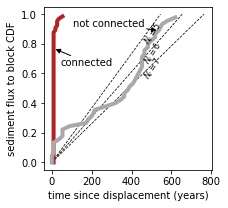

Aggregated across all simulation, when does sediment reach each block.
Black dashed lines represent the null hypothesis for avulsion controlled behavior with a mean frequency and a number of occupable lobes.


In [48]:
# empirical data
sort_c, prob_c = compute_ecdf(_bp_data_getsed[1].values)
sort_nc, prob_nc = compute_ecdf(_bp_data_getsed[0].values)

# model
T_A = 109  # avulsion timescale


# make the plot
fig, ax = plt.subplots(figsize=(3, 3))

# plot some models
for i in range(5, 8):
    N_L = i   # number lobes / spots to avulse to
    mdl_time_all = (T_A * N_L)
    _x = np.array([0, mdl_time_all])
    _y = np.array([0, 1])
    ax.plot(_x, _y, 'k--', lw=0.75)
    _textx = 450
    _texty = np.interp(_textx, _x, [0, 1])
    ax.text(_textx, _texty-0.02, f'$N_l=${N_L}',
            rotation=np.degrees(np.cos(ax.transAxes.transform((_textx, _texty))[1] / ax.transAxes.transform((_textx, _texty))[0])),
            fontsize=8)  # to get degrees working, need to convert lengths to axes coordinates and then compute angle?

# plot the CDFs
ax.plot(sort_c, prob_c, color=connect_colors[1], lw=4)
ax.plot(sort_nc, prob_nc, color=connect_colors[0], lw=4)

ax.annotate('connected', xy=(sort_c[-15], prob_c[-15]), xytext=(sort_c[-5]+150, prob_c[-5]-0.25),
           arrowprops=arrowpropsdict, va='center', ha='center')
ax.annotate('not connected', xy=(sort_nc[-5], prob_nc[-5]), xytext=(sort_nc[-5]-250, prob_nc[-5]+0.05),
           arrowprops=arrowpropsdict, va='center', ha='center')

ax.set_ylabel('sediment flux to block CDF')
ax.set_xlabel('time since displacement (years)')

plt.show()
print("Aggregated across all simulation, when does sediment reach each block.")
print("Black dashed lines represent the null hypothesis for avulsion controlled behavior with a mean frequency and a number of occupable lobes.")